# **Optimizing Kidney Paired Donation Using Cycles of 2 and 3 Nodes**

Author: Jairo Rodriguez

<hr style="height: 3px; border:none; color:#000; background-color:#000;" />

### **GOAL:**
<div style="text-align: justify;">
The goal of this project is to develop a graph-based optimization model for Kidney Paired Donation (KPD), aiming to maximize compatible donor-recipient matches within cycles of size 2 and 3. By constructing a directed graph based on compatibility rules, detecting feasible cycles, and formulating an optimization problem, the model ensures that each participant is included in at most one cycle. This approach aims to streamline the logistical coordination of kidney exchange programs, optimizing the matching process to facilitate efficient and practical transplantation planning.

</div>

In [1]:
# Optimization Library
import gurobipy as gp
from gurobipy import GRB

# Data Processing and Graphs
import json
import pandas as pd
import networkx as nx

# Visualization
import pprint
import matplotlib.pyplot as plt
import seaborn as sns

<br><br>
### **1. Loading and Printing Dataset**
This section reads the JSON file containing donor-recipient data, loads it into memory, and prints each record in a structured and readable format

In [4]:
# Open and read the JSON file
with open('JRB.json', 'r') as file:
    data = json.load(file)

# Print the data
# Iterate through each record in the data and display its content
pp = pprint.PrettyPrinter(indent=2)

max_records = 10 # Limit the number of records to print
for i, record in enumerate(data[:max_records], start=1):
    print(f"Record {i}:")
    for key, value in record.items():
        print(f"    {key}: {value}")   

print(f"\nDisplayed {max_records} out of {len(data)} records.")  

Record 1:
    Recipient: B
    Donor: ['AB']
Record 2:
    Recipient: B
    Donor: ['AB']
Record 3:
    Recipient: B
    Donor: ['A']
Record 4:
    Recipient: B
    Donor: ['AB', 'A']
Record 5:
    Recipient: B
    Donor: ['AB']
Record 6:
    Recipient: A
    Donor: ['AB']
Record 7:
    Recipient: A
    Donor: ['AB', 'B']
Record 8:
    Recipient: A
    Donor: ['B']
Record 9:
    Recipient: O
    Donor: ['AB', 'A']
Record 10:
    Recipient: A
    Donor: ['AB']

Displayed 10 out of 749 records.


<br><br>
### **2. Preliminary Data Analysis for Recipient Distribution**
To assess the size of the dataset and identify the frequency distribution of recipient types

In [5]:
# Count the total number of records
total_records = len(data)  # Get the total number of records in the dataset

# Count unique occurrences of each recipient type
recipients = [record['Recipient'] for record in data]

# Count the frequency of each unique recipient type
unique_recipients_count = {recipient: recipients.count(recipient) for recipient in set(recipients)}

# Create the summary result
summary = {
    "Total Records": total_records,
    "Recipient Type Counts": unique_recipients_count,
}

print(f'Total Records: {summary["Total Records"]}')
print("Recipient Type Counts:")
for recipient, count in summary['Recipient Type Counts'].items():
    print(f"  {recipient}: {count}")




Total Records: 749
Recipient Type Counts:
  B: 257
  O: 240
  A: 252


#### **Visualization and Analysis of Recipient Distribution**

In [6]:
# Create a DataFrame from the provided data
data_JRB = pd.DataFrame(data)

# Calculate the counts of each type of Recipient
recipient_counts = data_JRB["Recipient"].value_counts().reset_index()
recipient_counts.columns = ["Recipient", "Count"]

# Calculate percentages for each Recipient type
total = recipient_counts["Count"].sum()
recipient_counts["Percentage"] = ((recipient_counts["Count"] / total) * 100).round(2)

recipient_counts


,Recipient,Count,Percentage
0,B,257,34.31
1,A,252,33.64
2,O,240,32.04


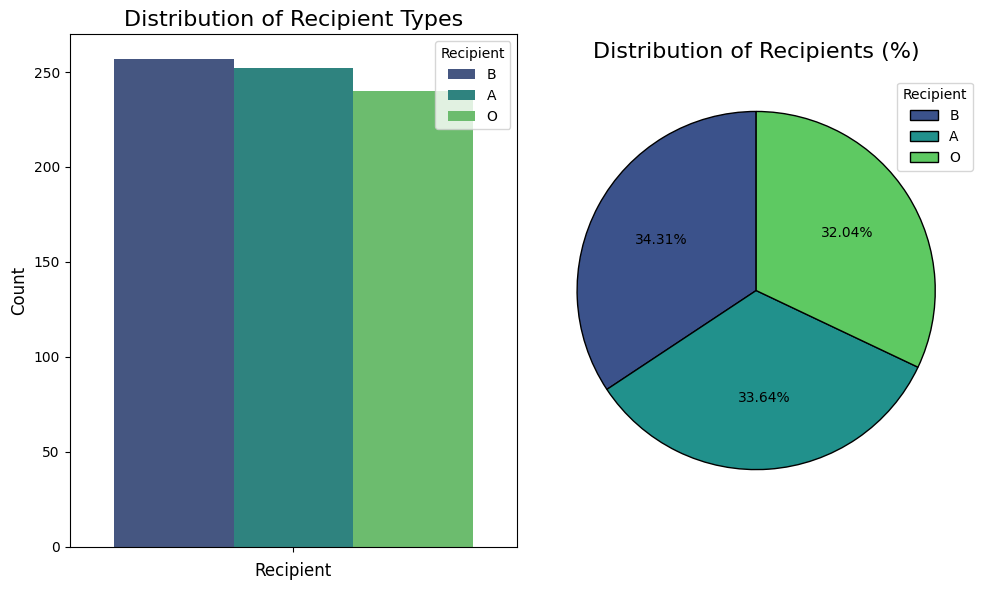

In [7]:
colors = sns.color_palette("viridis", len(recipient_counts))
fig, axes = plt.subplots(1, 2, figsize=(10, 6))  # 1 row, 2 columns

# Bar plot
sns.barplot(y="Count", hue="Recipient", data=recipient_counts, palette="viridis", ax=axes[0])
axes[0].set_title("Distribution of Recipient Types", fontsize=16)
axes[0].set_xlabel("Recipient", fontsize=12)
axes[0].set_ylabel("Count", fontsize=12)

# Pie chart
axes[1].pie(
    recipient_counts["Percentage"],
    labels=None,  
    autopct='%1.2f%%', 
    startangle=90,      
    colors=colors, 
    wedgeprops={'edgecolor': 'black'} 
)
axes[1].legend(
    labels=recipient_counts["Recipient"],  
    title="Recipient", 
    loc="upper right",
    bbox_to_anchor=(1, 0.98)  
)
axes[1].set_title("Distribution of Recipients (%)", fontsize=16) 

plt.tight_layout()
plt.show()


**CONCLUSIONS:**
- The distribution of Recipient types (B, A, O) is well-balanced, with differences of less than 2.5%:
    - B is the most frequent at 34.31%.
    - A follows closely with 33.64%.
    - O is the least frequent at 32.04%.
- This balance ensures no significant bias toward any Recipient type, providing a fair foundation for analyses involving transfers or compatibility with Donors.

<br><br>
### **3. Graph Construction for Donor-Recipient Compatibility**
This section constructs a directed graph (DiGraph) to model donor-recipient relationships, creating nodes for each record and edges based on blood type compatibility rules.

In [8]:
# Create a graph
G = nx.DiGraph() # Create an empty directed graph

# PART 1. CREATE NODES
counter = 0
for element in data:
    G.add_nodes_from([(counter, element)])
    counter += 1

print("Gnodes:")
print(f'Number of Nodes: {len(G.nodes)}')

# Define the donor-recipient compatibility rules based on blood types
donor_recipient_compatibility = {
    'O': ['O', 'A', 'B', 'AB'],  # Blood type 'O' can donate to all
    'A': ['A', 'AB'],            # Blood type 'A' can donate to 'A' and 'AB'
    'B': ['B', 'AB'],            # Blood type 'B' can donate to 'B' and 'AB'
    'AB': ['AB']                 # Blood type 'AB' can only donate to 'AB'
}

# PART 2. CREATE EDGES

for node in G.nodes:
    donors = G.nodes[node]['Donor'] # Get the donor blood types from the current node
    for donor in donors: # Iterate through each donor blood type
        for vertex in G.nodes:
            if node == vertex: 
                continue
            recipient = G.nodes[vertex]['Recipient'] # Get the recipient blood type from the vertex
            if recipient not in donor_recipient_compatibility[donor]: 
                continue
            G.add_edge(node, vertex) # Add an edge if compatible 

Gnodes:
Number of Nodes: 749


**Graph visualization:** This code creates a star-type graph visualization highlighting recipients as central nodes with directed edges from donors to their corresponding recipients.

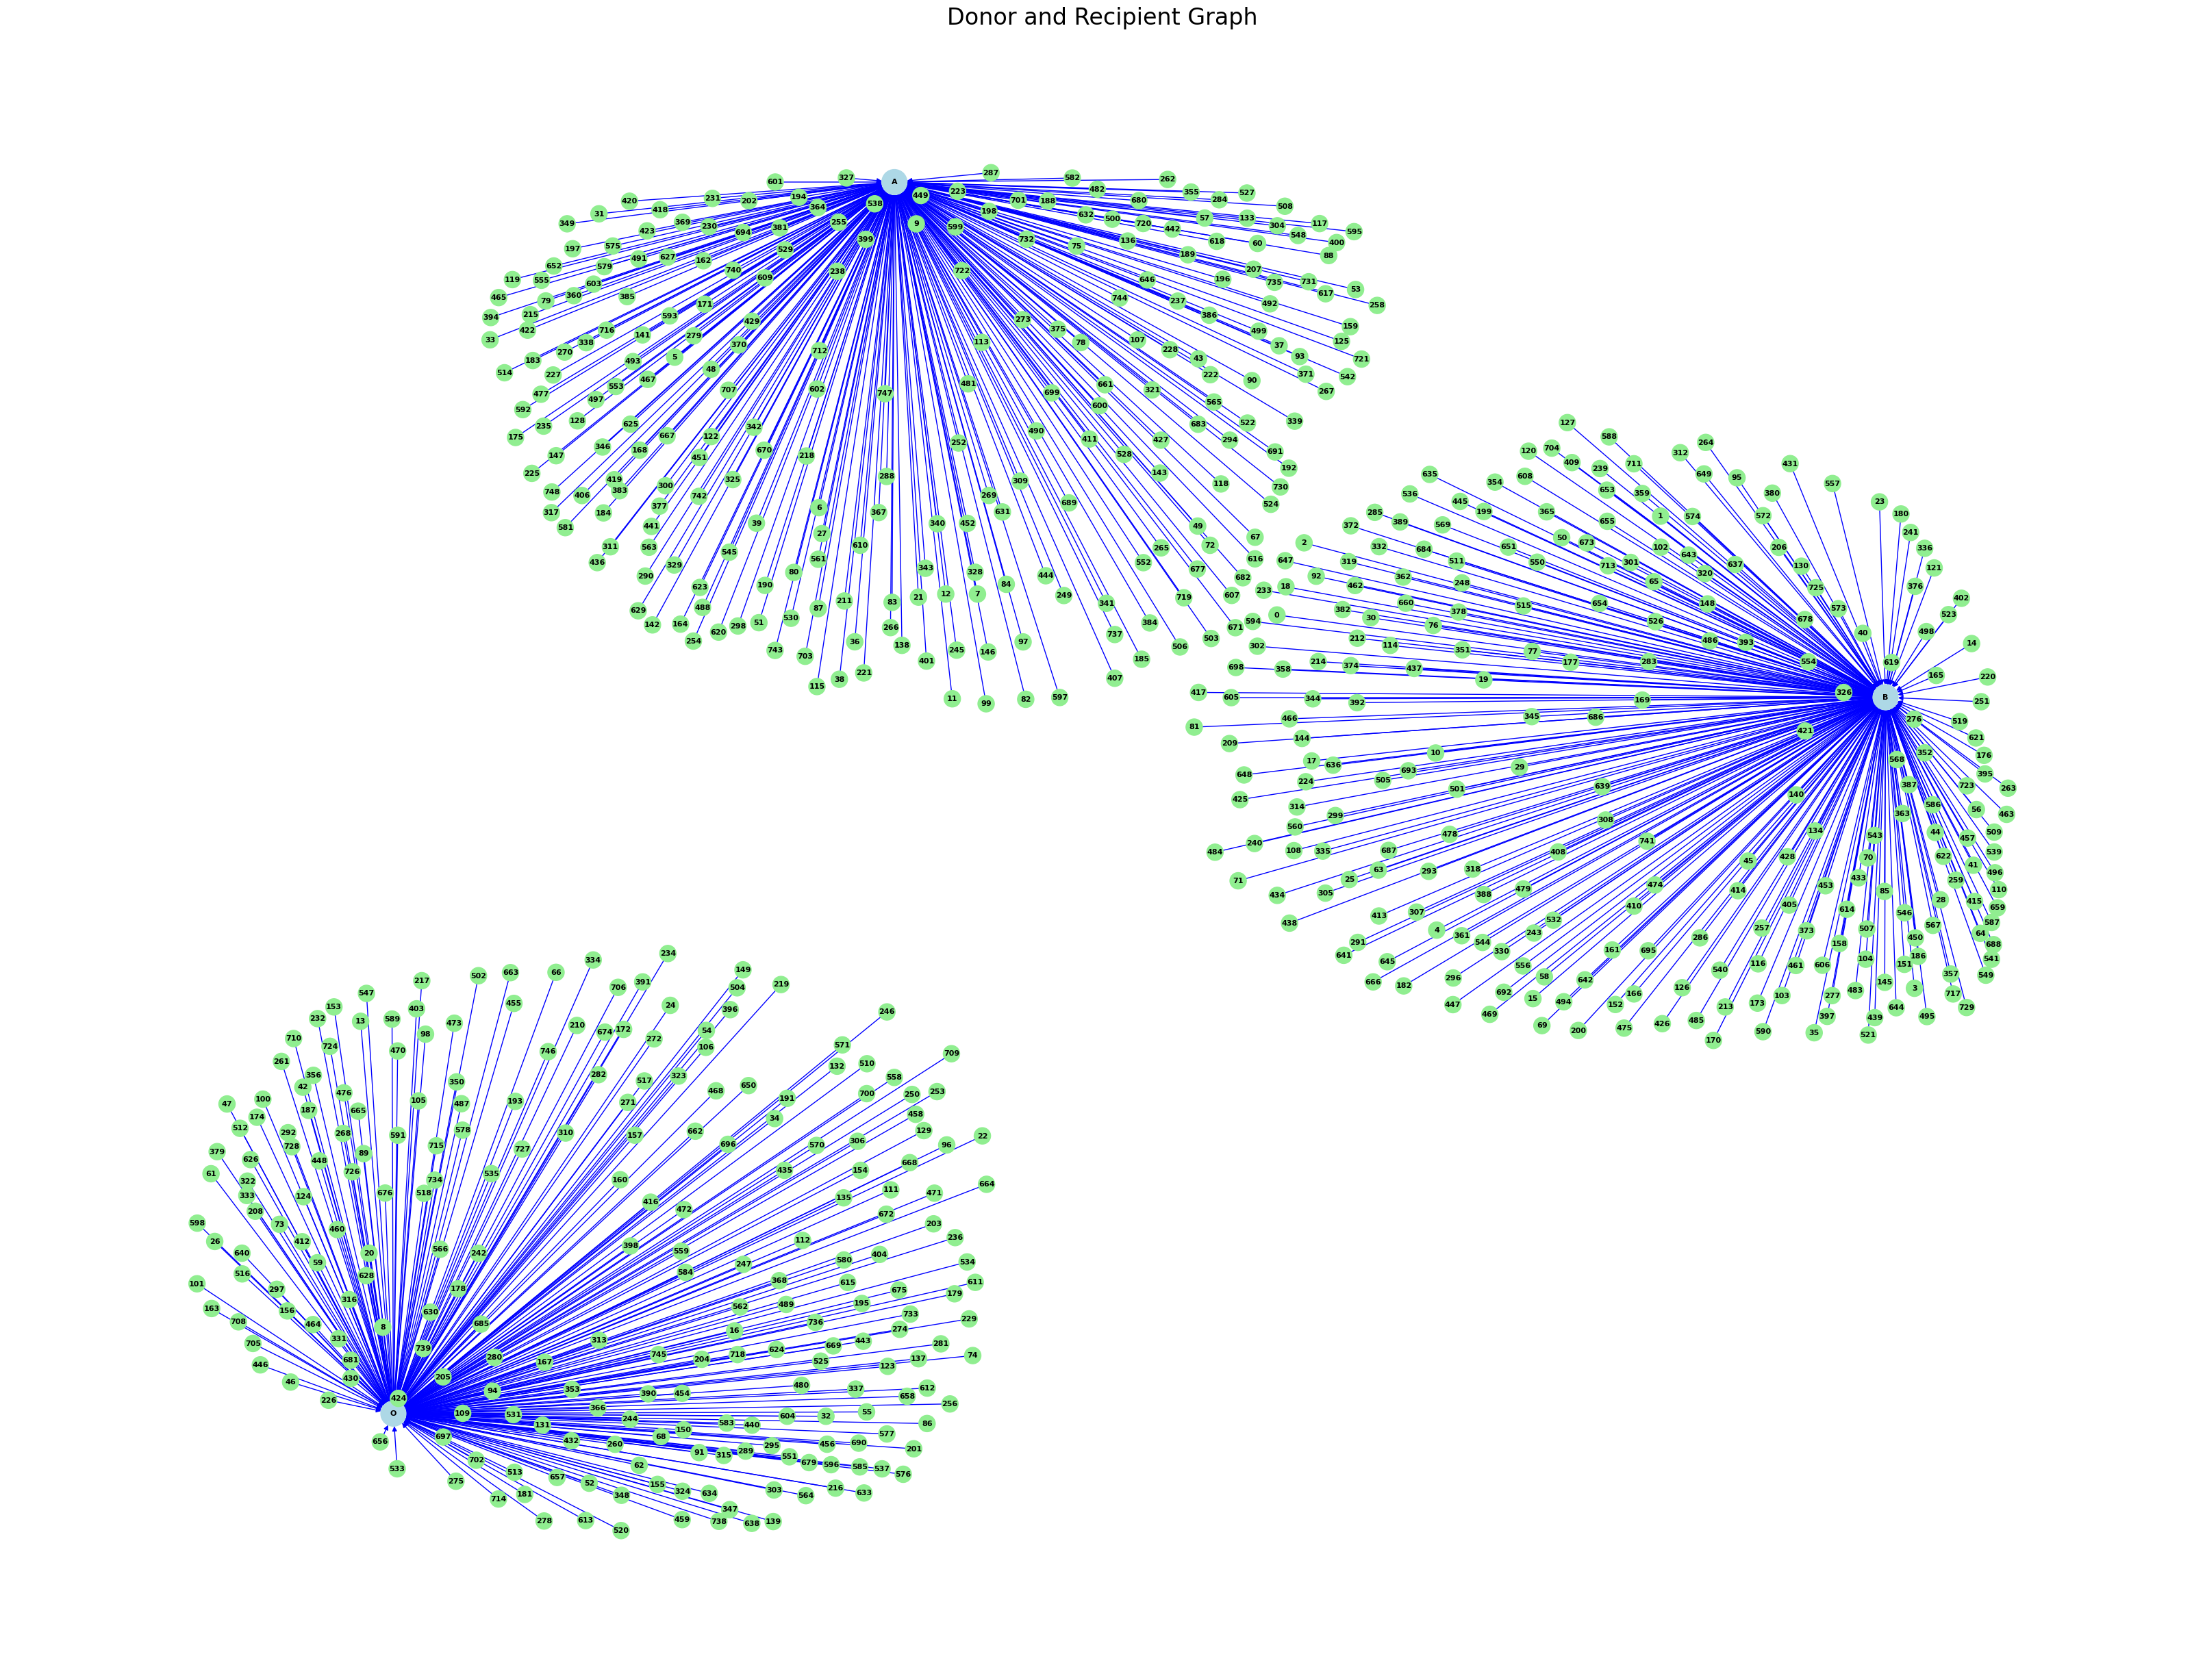

In [9]:
# Graph configuration for a star-type visualization
star_graph = nx.DiGraph()

# Add nodes for the recipients
recipients = ['A', 'B', 'O']
for recipient in recipients:
    star_graph.add_node(recipient, color='lightblue', size=700)

# Connect donors to recipients
for idx, (node, data) in enumerate(G.nodes(data=True)):
    donor = node
    recipient = data['Recipient']
    star_graph.add_node(donor, color='lightgreen', size=300) 
    star_graph.add_edge(donor, recipient) 


pos = nx.spring_layout(star_graph, seed=42, k=0.2)
node_colors = [nx.get_node_attributes(star_graph, 'color')[n] for n in star_graph.nodes()]
node_sizes = [nx.get_node_attributes(star_graph, 'size')[n] for n in star_graph.nodes()]

# Draw the graph 
plt.figure(figsize=(32, 24))
nx.draw(
    star_graph, pos,
    with_labels=True,
    node_color=node_colors,
    node_size=node_sizes,
    edge_color="blue",
    font_size=8, 
    font_weight="bold"
)
plt.title("Donor and Recipient Graph", fontsize=24)
plt.show()

<br><br>
### **4. Cycle Detection in the Graph**
This section identifies and prints unique 2-node and 3-node cycles in the directed graph by checking edge relationships and verifying cycle closure conditions


In [ ]:
# Step 1: Identify 2-node cycles
edges = set(G.edges()) 
cycles_of_size_2 = set()  # Initialize a set to store unique 2-node cycles

# Iterate through all edges to check for reciprocal relationships
for u, v in edges:
    if (v, u) in edges:  # Check if the reverse edge exists, indicating a cycle (edge relationship)
        pair = tuple(sorted([u, v])) 
        cycles_of_size_2.add(pair)  # Add the cycle to the set of unique 2-node cycles

# Print the detected 2-node cycles
max_cases_to_display = 30 # Maximum number of cases to display
print(f"Number of cases: {len(cycles_of_size_2)}") 
case = 1
for pair in list(cycles_of_size_2)[:max_cases_to_display]: 
    u, v = pair
    print(f"Case {case}: {u} -> {v} -> {u}") 
    case += 1

# Print summary of displayed cases
print(f"\nDisplayed {max_cases_to_display} out of {len(cycles_of_size_2)} cases.")

Number of cases: 43681
Case 1: 192 -> 319 -> 192
Case 2: 357 -> 386 -> 357
Case 3: 362 -> 730 -> 362
Case 4: 496 -> 730 -> 496
Case 5: 95 -> 386 -> 95
Case 6: 21 -> 437 -> 21
Case 7: 380 -> 555 -> 380
Case 8: 70 -> 329 -> 70
Case 9: 586 -> 623 -> 586
Case 10: 245 -> 330 -> 245
Case 11: 314 -> 689 -> 314
Case 12: 374 -> 740 -> 374
Case 13: 33 -> 447 -> 33
Case 14: 186 -> 689 -> 186
Case 15: 220 -> 273 -> 220
Case 16: 338 -> 494 -> 338
Case 17: 450 -> 735 -> 450
Case 18: 524 -> 684 -> 524
Case 19: 12 -> 509 -> 12
Case 20: 7 -> 165 -> 7
Case 21: 48 -> 166 -> 48
Case 22: 526 -> 730 -> 526
Case 23: 130 -> 730 -> 130
Case 24: 259 -> 386 -> 259
Case 25: 364 -> 402 -> 364
Case 26: 80 -> 643 -> 80
Case 27: 451 -> 556 -> 451
Case 28: 602 -> 725 -> 602
Case 29: 354 -> 623 -> 354
Case 30: 60 -> 176 -> 60

Displayed 30 out of 43681 cases.


In [12]:
#Step 2: Identify 3-node cycles
cycles_of_size_3 = {}  # Dictionary to store 3-node cycles with their edges
case_num = 1

for u in G.nodes:
    for v in G.successors(u):  # Explore successors of node u
        for w in G.successors(v):  # Explore successors of node v
            if G.has_edge(w, u):  # Check if there's an edge w -> u
                cycle = tuple(sorted([u, v, w]))  # Create a sorted tuple to identify unique cycles
                if cycle not in cycles_of_size_3:
                    # Store the 3-node cycle with its edges
                    cycles_of_size_3[cycle] = [(u, v), (v, w), (w, u)]
                    case_num += 1

# Print the detected 3-node cycles
print(f"\nTotal number of 3-node cycles: {len(cycles_of_size_3)}")
for cycle, edges in cycles_of_size_3.items():
    print(f"Cycle: {cycle[0]} -> {cycle[1]} -> {cycle[2]} -> {cycle[0]}")




Total number of 3-node cycles: 0


**CONCLUSIONS:**
- A total of 43,681 reciprocal 2-node cycles (bidirectional relationships between node pairs) were identified in the graph.
- The analysis revealed 0 three-node cycles, indicating the absence of triangular relationships among nodes. This implies that the network lacks closed loops involving three nodes.

<br><br>
### **5. Optimization Model for Cycle Selection**
This section formulates and solves an optimization model to maximize the selection of 2-node and 3-node cycles, implicitly maximizing the number of nodes covered in the graph (considering only cycles of 2 and 3 nodes).

**Variables:**

- $x_{ij}$: Binary variable for a 2-node cycle, where $i$ and $j$ represent the two nodes in the cycle $(i \to j) \text{ and } (j \to i)$, and:
  $$
  x_{ij} =
  \begin{cases} 
  1 & \text{if the cycle is selected,} \\
  0 & \text{otherwise.}
  \end{cases}
  $$

- $y_{ijk}$: Binary variable for a 3-node cycle, where $(i, j, k)$ represent the three nodes in the cycle $(i \to j \to k \to i)$, and:
  $$
  y_{ijk} =
  \begin{cases} 
  1 & \text{if the cycle is selected,} \\
  0 & \text{otherwise.}
  \end{cases}
  $$


**Objective Function:**

Maximize the total number of selected cycles:

$$
\text{Maximize}\left[ \sum_{(i,j) \in \text{Cycles of Size 2}} x_{ij} + \sum_{(i,j,k) \in \text{Cycles of Size 3}} y_{ijk}\right]
$$


**Constraints:**

- Each node $i$ can participate in at most one cycle (either a 2-node cycle or a 3-node cycle):

$$
\sum_{(i,j) \in \text{Cycles of Size 2}} x_{ij} + \sum_{(j,k) \in \text{Cycles of Size 3 where } i \in \{j,k\}} y_{ijk} \leq 1
$$

- Constraint for 2-node cycles:

$$
x_{ij} \in \{0, 1\}, \quad \forall \{i, j\} \in \text{cycles of size 2}
$$

- Constraint for 3-node cycles:

$$
y_{ijk} \in \{0, 1\}, \quad \forall \{i, j, k\} \in \text{cycles of size 3}
$$

In [13]:
# Initialize the optimization model
m = gp.Model()

# Create binary variables for cycle selection (unified for 2-node and 3-node cycles)
x = m.addVars(
    list(cycles_of_size_2) + list(cycles_of_size_3.keys()),
    vtype=GRB.BINARY,
    name="x"
)

# Objective function: Maximize the number of selected cycles
m.setObjective(
    gp.quicksum(x[cycle] for cycle in cycles_of_size_2) +
    gp.quicksum(x[cycle] for cycle in cycles_of_size_3.keys()),
    GRB.MAXIMIZE
)

# Constraint: Each node can participate in at most one cycle
for node in G.nodes:
    # Sum of 2-node cycles involving this node
    cycles_2 = gp.quicksum(x[cycle] for cycle in cycles_of_size_2 if node in cycle)

    # Sum of 3-node cycles involving this node
    cycles_3 = gp.quicksum(
        x[cycle] for cycle in cycles_of_size_3.keys() if node in cycle
    )

    # Add the constraint: The sum of cycles (2-node and 3-node) involving this node must be ≤ 1
    m.addConstr(cycles_2 + cycles_3 <= 1, name=f"node_{node}_participation")

# Solve the optimization model
m.optimize()


Set parameter Username
Academic license - for non-commercial use only - expires 2025-09-13
Gurobi Optimizer version 11.0.3 build v11.0.3rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-8650U CPU @ 1.90GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 749 rows, 43681 columns and 87362 nonzeros
Model fingerprint: 0x93f61516
Variable types: 0 continuous, 43681 integer (43681 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [1e+00, 1e+00]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 209.0000000
Presolve removed 331 rows and 0 columns
Presolve time: 0.21s
Presolved: 418 rows, 43681 columns, 87362 nonzeros
Variable types: 0 continuous, 43681 integer (43681 binary)

Root relaxation: cutoff, 1266 iterations, 0.18 seconds (0.12 work units)

    Nodes    |    Current Node    |     Objective Bounds

**CONCLUSIONS:**
- The optimization resulted in 209 selected cycles, which includes the maximum number of non-overlapping cycles.
- The solver achieved an optimal solution with a gap of 0.0000%.
- Out of the 43,681 detected 2-node cycles, only 209 were selected due to the constraint that each node can participate in at most one cycle.
- Since no 3-node cycles were present, the solution exclusively focuses on 2-node cycles

<br><br>
### **6. Extracting and Displaying Selected Cycles**
This section extracts the selected 2-node and 3-node cycles from the optimization model's solution and prints their details, including the number of selected cycles and their node sequences.

In [14]:
# Extract the selected 2-node cycles
selected_cycles_2 = [pair for pair in cycles_of_size_2 if x[pair].X > 0.5]

# Extract the selected 3-node cycles
selected_cycles_3 = [cycle for cycle in cycles_of_size_3.keys() if x[cycle].X > 0.5]

max_cycles_to_display = 30 # Maximum number of cycles to display

# Print the selected 2-node cycles
print(f"\nNumber of selected 2-node cycles: {len(selected_cycles_2)}")
for i, cycle in enumerate(selected_cycles_2[:max_cycles_to_display], 1):
    print(f"Selected 2-node Cycle {i}: {cycle[0]} -> {cycle[1]} -> {cycle[0]}")
print(f"\nDisplayed {min(len(selected_cycles_2), max_cycles_to_display)} out of {len(selected_cycles_2)} selected 2-node cycles.")

# Print the selected 3-node cycles
print(f"\nNumber of selected 3-node cycles: {len(selected_cycles_3)}")
for i, cycle in enumerate(selected_cycles_3[:max_cycles_to_display], 1):
    edges = cycles_of_size_3[cycle]
    print(f"Selected 3-node Cycle {i}: {edges[0][0]} -> {edges[0][1]} -> {edges[1][1]} -> {edges[2][1]} -> {edges[0][0]}")
print(f"\nDisplayed {min(len(selected_cycles_3), max_cycles_to_display)} out of {len(selected_cycles_3)} selected 3-node cycles.")



Number of selected 2-node cycles: 209
Selected 2-node Cycle 1: 192 -> 319 -> 192
Selected 2-node Cycle 2: 357 -> 386 -> 357
Selected 2-node Cycle 3: 362 -> 730 -> 362
Selected 2-node Cycle 4: 21 -> 437 -> 21
Selected 2-node Cycle 5: 380 -> 555 -> 380
Selected 2-node Cycle 6: 70 -> 329 -> 70
Selected 2-node Cycle 7: 586 -> 623 -> 586
Selected 2-node Cycle 8: 245 -> 330 -> 245
Selected 2-node Cycle 9: 314 -> 689 -> 314
Selected 2-node Cycle 10: 374 -> 740 -> 374
Selected 2-node Cycle 11: 33 -> 447 -> 33
Selected 2-node Cycle 12: 220 -> 273 -> 220
Selected 2-node Cycle 13: 338 -> 494 -> 338
Selected 2-node Cycle 14: 450 -> 735 -> 450
Selected 2-node Cycle 15: 524 -> 684 -> 524
Selected 2-node Cycle 16: 12 -> 509 -> 12
Selected 2-node Cycle 17: 7 -> 165 -> 7
Selected 2-node Cycle 18: 48 -> 166 -> 48
Selected 2-node Cycle 19: 364 -> 402 -> 364
Selected 2-node Cycle 20: 80 -> 643 -> 80
Selected 2-node Cycle 21: 451 -> 556 -> 451
Selected 2-node Cycle 22: 602 -> 725 -> 602
Selected 2-node Cy

In [12]:
# Create a list to summarize the 2-node cycles

# Each entry contains the cycle number, donors, and recipients
cycles_2_data = [
    {
        'Cycle': i + 1,
        'Donor 1': cycle[0],  # First donor in the cycle
        'Recipient 1': G.nodes[cycle[0]]['Recipient'],  # Recipient for the first donor
        'Donor 2': cycle[1],  # Second donor in the cycle
        'Recipient 2': G.nodes[cycle[1]]['Recipient']  # Recipient for the second donor
    }
    for i, cycle in enumerate(selected_cycles_2) 
]

df_cycles_2 = pd.DataFrame(cycles_2_data)
df_cycles_2.to_excel('2_node_cycles_summary.xlsx', index=False)
df_cycles_2.head(10).style.hide(axis='index')



Cycle,Donor 1,Recipient 1,Donor 2,Recipient 2
1,192,A,319,B
2,357,B,386,A
3,362,B,730,A
4,21,A,437,B
5,380,B,555,A
6,70,B,329,A
7,586,B,623,A
8,245,A,330,B
9,314,B,689,A
10,374,B,740,A


**Interpretation of the Table**

This table summarizes the 2-node cycles selected by the optimization model for kidney exchange. The full table can be found in the generated Excel file (2_node_cycles_summary.xlsx). Each row represents one cycle, detailing the connections between two donor-recipient pairs:

- Cycle:
    - Sequential number assigned to each cycle for reference.
    - Example: Row 1 corresponds to Cycle 1.
- Donor 1 & Recipient 1:
    - The first donor in the cycle and their corresponding recipient.
    - Example: In Cycle 1, Donor 192 donates to Recipient B (Node 319).
- Donor 2 & Recipient 2:
    - The second donor in the cycle and their corresponding recipient.
    - Example: In Cycle 1, Donor 319 donates to Recipient A (Node 192).

**How to Read a Cycle**: Each cycle represents a reciprocal kidney exchange between two pairs:
- Cycle 1:
    - Donor 192 gives to Recipient B (Node 319).
    - Donor 319 gives to Recipient A (Node 192).
- Cycle 2:
    - Donor 357 gives to Recipient A (Node 386).
    - Donor 386 gives to Recipient B (Node 357).

<br><br>
### **7. Identifying Included and Excluded Nodes**
This section identifies the nodes included in the selected cycles and determines the nodes excluded from the solution

In [13]:
# Identify nodes included in the selected cycles
included_nodes = set()

# Add nodes from the selected 2-node cycles
for cycle in selected_cycles_2:
    included_nodes.update(cycle)  

# Add nodes from the selected 3-node cycles
for cycle in selected_cycles_3:
    included_nodes.update(cycle)

# Determine nodes that are not included
all_nodes = set(G.nodes)
excluded_nodes = all_nodes - included_nodes
len_included_nodes = len(included_nodes)
len_excluded_nodes = len(excluded_nodes)

# Print the results
print("\nNodes included in the solution:")
print(f"Total: {len_included_nodes}")
print(included_nodes)

print("\nNodes not included in the solution:")
print(f"Total: {len_excluded_nodes}")
print(excluded_nodes)



Nodes included in the solution:
Total: 418
{2, 3, 6, 7, 10, 12, 14, 15, 17, 18, 19, 21, 23, 25, 27, 28, 30, 31, 33, 36, 37, 38, 39, 40, 41, 43, 45, 48, 49, 50, 51, 56, 58, 60, 63, 64, 65, 69, 70, 71, 77, 78, 79, 80, 81, 82, 83, 84, 90, 92, 93, 95, 97, 99, 102, 103, 107, 110, 113, 114, 115, 116, 117, 119, 120, 121, 122, 125, 126, 127, 130, 134, 136, 138, 140, 141, 142, 144, 145, 147, 151, 152, 158, 159, 161, 164, 165, 166, 168, 170, 173, 175, 176, 177, 180, 182, 183, 184, 185, 186, 188, 189, 190, 192, 194, 196, 197, 198, 199, 200, 202, 206, 207, 209, 211, 213, 214, 215, 220, 221, 222, 223, 224, 225, 227, 228, 230, 231, 235, 237, 238, 239, 240, 241, 243, 245, 248, 251, 252, 254, 255, 257, 258, 259, 262, 263, 264, 265, 266, 269, 270, 273, 276, 277, 279, 283, 284, 285, 286, 287, 288, 290, 291, 293, 294, 298, 299, 301, 304, 305, 307, 308, 309, 311, 312, 314, 317, 319, 321, 325, 326, 327, 328, 329, 330, 336, 338, 341, 342, 343, 344, 346, 351, 352, 354, 355, 357, 358, 359, 360, 361, 362, 363

<br><br>
### **8. Analysis of Included and Excluded Nodes in Cycles**
This section analyzes the inclusion status of nodes based on recipient and donor attributes, visualizes the distribution and percentages of included and excluded nodes through charts and summary tables.

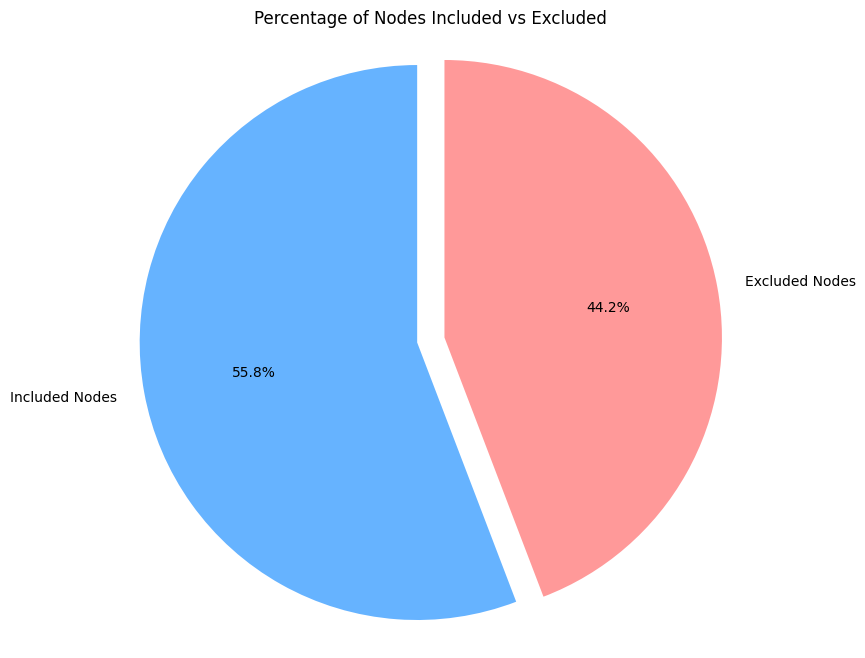

In [ ]:
# Visualization of Included vs Excluded Nodes Using a Pie Chart
# Data for the pie chart
labels = ['Included Nodes', 'Excluded Nodes']
sizes = [len_included_nodes, len_excluded_nodes]
colors = ['#66b3ff', '#ff9999'] 
explode = (0.1, 0) 

# Create the pie chart
plt.figure(figsize=(8, 8))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Percentage of Nodes Included vs Excluded')
plt.axis('equal')
plt.show()

In [ ]:
# Create a DataFrame to group nodes by 'Recipient' and inclusion status
node_data = []

# Add included nodes to the DataFrame
for node in included_nodes:
    recipient_type = G.nodes[node]['Recipient']
    node_data.append({'Recipient': recipient_type, 'Included': 1, 'Not Included': 0})

# Add excluded nodes to the DataFrame
for node in excluded_nodes:
    recipient_type = G.nodes[node]['Recipient']
    node_data.append({'Recipient': recipient_type, 'Included': 0, 'Not Included': 1})

df = pd.DataFrame(node_data)

# Summarize included and excluded nodes by 'Recipient'
recipient_table = df.groupby('Recipient').sum().reset_index()

# Print the summary table
print("\nSummary table of nodes by Recipient:")
recipient_table


Summary table of nodes by Recipient:


,Recipient,Included,Not Included
0,A,209,43
1,B,209,48
2,O,0,240


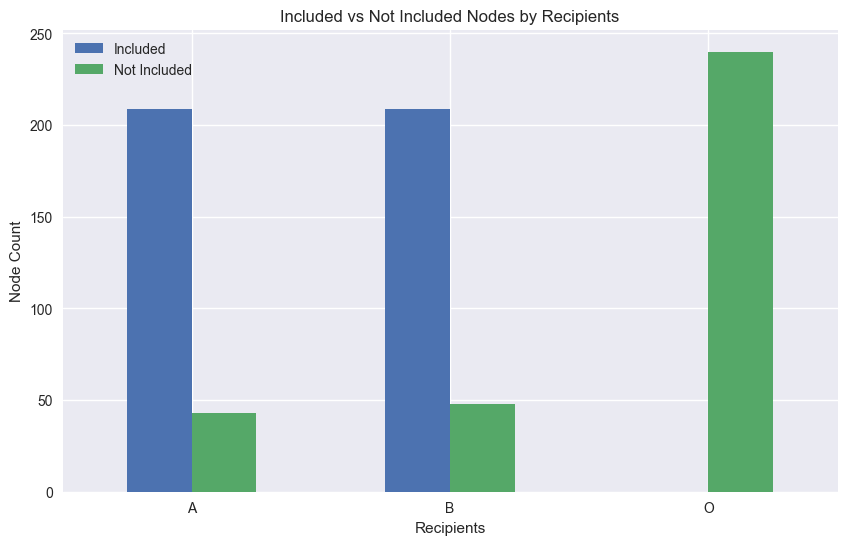

In [ ]:
# Bar Chart: Distribution of Included vs Not Included Nodes by Recipients
plt.style.use('seaborn-v0_8') 
recipient_table.plot(
    x='Recipient', 
    y=['Included', 'Not Included'], 
    kind='bar', 
    figsize=(10, 6)
)
plt.title('Included vs Not Included Nodes by Recipients')
plt.xlabel('Recipients')
plt.ylabel('Node Count')
plt.xticks(rotation=0)
plt.show()

In [ ]:
# Calculating Percentages for Included and Not Included Nodes by Recipients
recipient_table['Total'] = recipient_table['Included'] + recipient_table['Not Included']
recipient_table['Included %'] = ((recipient_table['Included'] / recipient_table['Total']) * 100).round(2)
recipient_table['Not Included %'] = ((recipient_table['Not Included'] / recipient_table['Total']) * 100).round(2)
recipient_table

,Recipient,Included,Not Included,Total,Included %,Not Included %
0,A,209,43,252,82.94,17.06
1,B,209,48,257,81.32,18.68
2,O,0,240,240,0.00,100.00


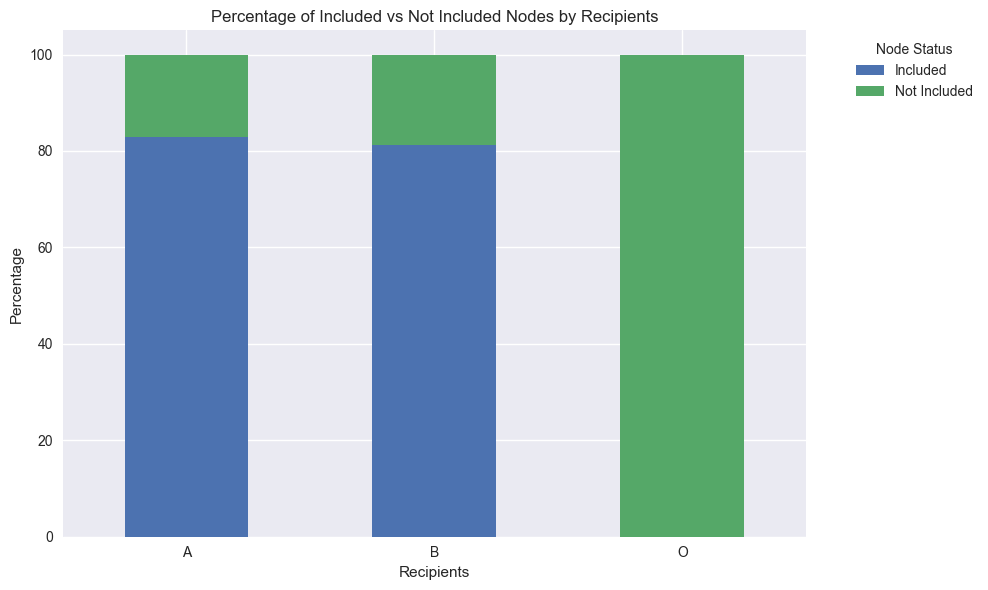

In [ ]:
# Stacked Bar Chart: Percentage of Included vs Not Included Nodes by Recipients
# Prepare the data for a stacked bar chart
percentages = recipient_table[['Recipient', 'Included %', 'Not Included %']].set_index('Recipient')

# Create a stacked bar chart
percentages.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    color=['#4C72B0', '#55A868']
)
plt.title('Percentage of Included vs Not Included Nodes by Recipients')
plt.xlabel('Recipients')
plt.ylabel('Percentage')
plt.xticks(rotation=0)
plt.legend(
    title='Node Status', 
    labels=['Included', 'Not Included'], 
    loc='upper left', 
    bbox_to_anchor=(1.05, 1)
)
plt.tight_layout()
plt.show()

In [ ]:
# Grouping Nodes by Donor Combinations
# Create a DataFrame to group nodes by 'Donor' combinations and inclusion status
node_data_donor = []

# Process included nodes
for node in included_nodes:
    donor_types = tuple(sorted(G.nodes[node]['Donor']))  # Convertir lista a tupla ordenada
    node_data_donor.append({'Donor': donor_types, 'Included': 1, 'Not Included': 0})

# Process excluded nodes
for node in excluded_nodes:
    donor_types = tuple(sorted(G.nodes[node]['Donor']))  # Convertir lista a tupla ordenada
    node_data_donor.append({'Donor': donor_types, 'Included': 0, 'Not Included': 1})

df_donor = pd.DataFrame(node_data_donor)

# Summarize counts by Donor combination
donor_table = df_donor.groupby('Donor').sum().reset_index()

# Print the summary table
print("\nSummary table of nodes by Donor combinations:")
donor_table



Summary table of nodes by Donor combinations:


,Donor,Included,Not Included
0,"(A,)",67,4
1,"(A, AB)",142,48
2,"(A, AB, B)",0,95
3,"(A, B)",0,40
4,"(AB,)",0,95
5,"(AB, B)",154,44
6,"(B,)",55,5


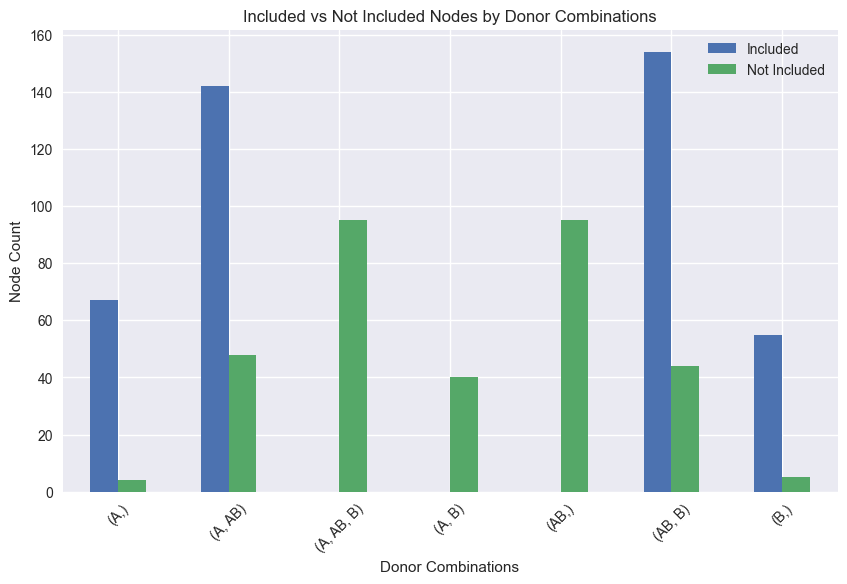

In [ ]:
# Bar Chart: Distribution of Included vs Not Included Nodes by Donor Combinations
plt.style.use('seaborn-v0_8') 
donor_table.plot(
    x='Donor', 
    y=['Included', 'Not Included'], 
    kind='bar', 
    figsize=(10, 6)
)
plt.title('Included vs Not Included Nodes by Donor Combinations')
plt.xlabel('Donor Combinations')
plt.ylabel('Node Count')
plt.xticks(rotation=45)
plt.show()

In [ ]:
# Calculating Percentages for Included and Not Included Nodes by Donor Combinations
donor_table['Total'] = donor_table['Included'] + donor_table['Not Included']
donor_table['Included %'] = ((donor_table['Included'] / donor_table['Total']) * 100).round(2)
donor_table['Not Included %'] = ((donor_table['Not Included'] / donor_table['Total']) * 100).round(2)
donor_table




,Donor,Included,Not Included,Total,Included %,Not Included %
0,"(A,)",67,4,71,94.37,5.63
1,"(A, AB)",142,48,190,74.74,25.26
2,"(A, AB, B)",0,95,95,0.00,100.00
3,"(A, B)",0,40,40,0.00,100.00
4,"(AB,)",0,95,95,0.00,100.00
5,"(AB, B)",154,44,198,77.78,22.22
6,"(B,)",55,5,60,91.67,8.33


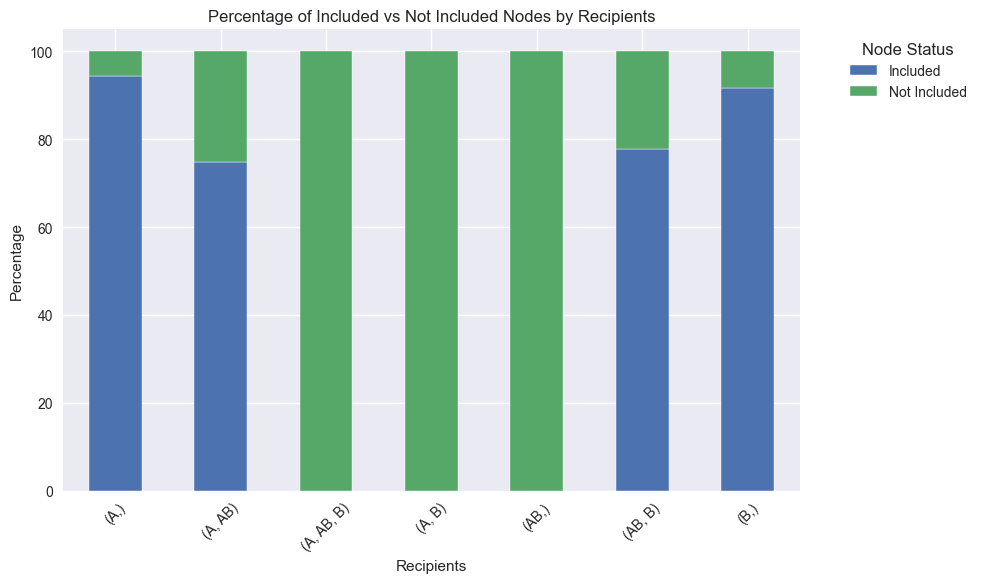

In [ ]:
# Stacked Bar Chart: Percentage of Included vs Not Included Nodes by Donor Combinations
# Prepare the data for a stacked bar chart
percentages = donor_table[['Donor', 'Included %', 'Not Included %']].set_index('Donor')

# Create a stacked bar chart
percentages.plot(
    kind='bar', 
    stacked=True, 
    figsize=(10, 6), 
    color=['#4C72B0', '#55A868']
)
plt.title('Percentage of Included vs Not Included Nodes by Recipients')
plt.xlabel('Recipients')
plt.ylabel('Percentage')
plt.xticks(rotation=45)
plt.legend(
    title='Node Status', 
    labels=['Included', 'Not Included'], 
    loc='upper left', 
    bbox_to_anchor=(1.05, 1)
)
plt.tight_layout()
plt.show()

**CONCLUSIONS:**
- **Inclusion vs Exclusion:**
    - In general, 55.8% of nodes are included, while 44.2% are excluded, indicating that a majority of nodes contribute to the solution.
- **Analysis by Recipients:**
    - Recipients A and B have the highest inclusion rates, with 82.94% and 81.32%, respectively.
    - Recipient O has 0% inclusion, with all 240 nodes excluded
- **Analysis by Donor Combinations:**
    - Donor (A): 94.37% of its nodes are included (67 out of 71).
    - Donor (B): 91.67% inclusion rate (55 out of 60).
    - Set of Donor (A, AB) and (AB, B) have inclusion rates of 74.74% and 77.78%, respectively, showing significant but not complete participation in cycles.
    - Set of Donors (A, AB, B), (A, B), and Donor (AB) have 0% inclusion, with all their nodes excluded, indicating these combinations do not form part of any cycles.
- The high inclusion rates for certain donor combinations suggest strong connectivity or compatibility between specific donors and recipients.

<Br><Br>
### **9. Finding a Node's Cycle in the Solution**
This code defines a function to search for a specific node within the cycles included in the optimization solution. It returns the cycle (either 2-node or 3-node) that contains the node or a message indicating that the node is not part of any cycle in the solution

In [35]:
# Results of previous analysis
print("\nNodes included in the solution:")
print(f"Total: {len_included_nodes}")
print(included_nodes)

print("\nNodes not included in the solution:")
print(f"Total: {len_excluded_nodes}")
print(excluded_nodes)


Nodes included in the solution:
Total: 418
{2, 3, 6, 7, 10, 12, 14, 15, 17, 18, 19, 21, 23, 25, 27, 28, 30, 31, 33, 36, 37, 38, 39, 40, 41, 43, 45, 48, 49, 50, 51, 56, 58, 60, 63, 64, 65, 69, 70, 71, 77, 78, 79, 80, 81, 82, 83, 84, 90, 92, 93, 95, 97, 99, 102, 103, 107, 110, 113, 114, 115, 116, 117, 119, 120, 121, 122, 125, 126, 127, 130, 134, 136, 138, 140, 141, 142, 144, 145, 147, 151, 152, 158, 159, 161, 164, 165, 166, 168, 170, 173, 175, 176, 177, 180, 182, 183, 184, 185, 186, 188, 189, 190, 192, 194, 196, 197, 198, 199, 200, 202, 206, 207, 209, 211, 213, 214, 215, 220, 221, 222, 223, 224, 225, 227, 228, 230, 231, 235, 237, 238, 239, 240, 241, 243, 245, 248, 251, 252, 254, 255, 257, 258, 259, 262, 263, 264, 265, 266, 269, 270, 273, 276, 277, 279, 283, 284, 285, 286, 287, 288, 290, 291, 293, 294, 298, 299, 301, 304, 305, 307, 308, 309, 311, 312, 314, 317, 319, 321, 325, 326, 327, 328, 329, 330, 336, 338, 341, 342, 343, 344, 346, 351, 352, 354, 355, 357, 358, 359, 360, 361, 362, 363

In [37]:
def find_cycle_for_node(node, selected_cycles_2, selected_cycles_3):
    # Search for the node in the selected 2-node cycles
    for cycle in selected_cycles_2:
        if node in cycle:
            return f"Cycle of size 2: {cycle[0]} -> {cycle[1]} -> {cycle[0]}"

    # Search for the node in the selected 3-node cycles
    for cycle in selected_cycles_3:
        if node in cycle:
            return f"Cycle of size 3: {cycle[0]} -> {cycle[1]} -> {cycle[2]} -> {cycle[0]}"
    
    # If the node is not part of any cycle in the solution
    return f"No cycle includes the node {node}."

# Prompt the user to enter a node
node_to_check = input("Enter the node to find its cycle: ")

if node_to_check.isdigit():
    node_to_check = int(node_to_check)
    result = find_cycle_for_node(node_to_check, selected_cycles_2, selected_cycles_3)
    print(result)
else:
    print("Invalid input. Please enter a valid node number.")



No cycle includes the node 20.
